# Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import joblib
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Data Loading

In [2]:
df = pd.read_csv("dataset_intent_general_100.csv")
df

,Kalimat Pengguna,Intent
0,Tampilkan semua data anak usia di bawah lima t...,search_data
1,Berapa jumlah keluarga yang sudah terdaftar?,aggregate_query
2,Apa itu kartu KIA?,faq_general
3,Jadwal kegiatan kesehatan bulan ini apa saja?,external_event_query
4,Cek nama ibu yang punya anak lebih dari dua.,search_data
...,...,...
95,Kapan ada penyuluhan gizi lagi?,external_event_query
96,Tampilkan warga dengan status ibu hamil.,search_data
97,Jumlah keluarga miskin tahun ini berapa?,aggregate_query
98,Apa yang dimaksud dengan kader posyandu?,faq_general


# Data Preprocessing

In [4]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]', '', text)
    text = re.sub(r'#[A-Za-z0-9]', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)

    text = text.replace('\n', ' ') 
    text = text.translate(str.maketrans('', '', string.punctuation)) 
    text = text.strip(' ') 
    return text

def casefoldingText(text):
    text = text.lower()
    return text

custom_stopwords = [
    "yang", "di", "ke", "dari", "dengan", "dan", "atau", "untuk", "pada",
    "karena", "agar", "supaya", "bagi", "sebagai", "oleh", "dalam", "adalah",
    "itu", "ini", "juga", "sehingga", "bahwa", "lebih", "kurang", "sudah",
    "masih", "telah", "akan", "tanpa", "hingga", "antara", "setelah", "sebelum",
    "dapat", "maupun", "jadi", "lalu", "kemudian", "per", "selama", "meskipun",
    "setiap", "tersebut", "seluruh", "selain", "namun"
]

def filteringText(text):
    filtered_text = [word for word in text if word not in custom_stopwords]
    return filtered_text

In [5]:
df['text_clean'] = df['Kalimat Pengguna'].apply(cleaningText)
df['text_ready'] = df['text_clean'].apply(casefoldingText)

In [6]:
df

,Kalimat Pengguna,Intent,text_clean,text_ready
0,Tampilkan semua data anak usia di bawah lima t...,search_data,Tampilkan semua data anak usia di bawah lima t...,tampilkan semua data anak usia di bawah lima t...
1,Berapa jumlah keluarga yang sudah terdaftar?,aggregate_query,Berapa jumlah keluarga yang sudah terdaftar,berapa jumlah keluarga yang sudah terdaftar
2,Apa itu kartu KIA?,faq_general,Apa itu kartu KIA,apa itu kartu kia
3,Jadwal kegiatan kesehatan bulan ini apa saja?,external_event_query,Jadwal kegiatan kesehatan bulan ini apa saja,jadwal kegiatan kesehatan bulan ini apa saja
4,Cek nama ibu yang punya anak lebih dari dua.,search_data,Cek nama ibu yang punya anak lebih dari dua,cek nama ibu yang punya anak lebih dari dua
...,...,...,...,...
95,Kapan ada penyuluhan gizi lagi?,external_event_query,Kapan ada penyuluhan gizi lagi,kapan ada penyuluhan gizi lagi
96,Tampilkan warga dengan status ibu hamil.,search_data,Tampilkan warga dengan status ibu hamil,tampilkan warga dengan status ibu hamil
97,Jumlah keluarga miskin tahun ini berapa?,aggregate_query,Jumlah keluarga miskin tahun ini berapa,jumlah keluarga miskin tahun ini berapa
98,Apa yang dimaksud dengan kader posyandu?,faq_general,Apa yang dimaksud dengan kader posyandu,apa yang dimaksud dengan kader posyandu


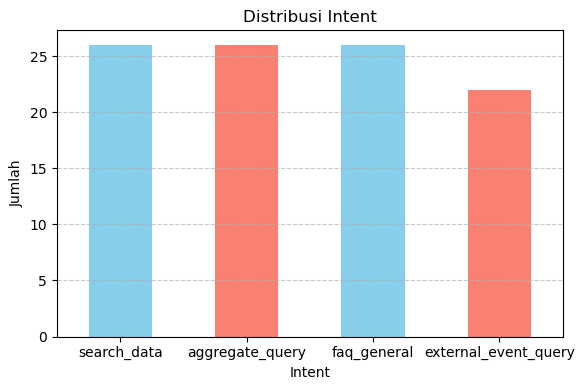

In [7]:
polarity_counts = df['Intent'].value_counts()

plt.figure(figsize=(6, 4))
polarity_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribusi Intent')
plt.xlabel('Intent')
plt.ylabel('Jumlah')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Data Splitting

In [ ]:
texts = df['text_ready'].astype(str).tolist()  
labels = df['Intent'].tolist()  

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

joblib.dump(label_encoder, 'label_encoder.pkl')

df['label_encoded'] = labels

X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    texts, labels, test_size=0.1, random_state=42)

# Model Training

In [ ]:
# ========== 1. Data Preprocessing (Tokenization + Padding) ==========
max_vocab = 10000
max_len = 100

# Tokenizer untuk teks
tokenizer = Tokenizer(num_words=max_vocab, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_texts)
tokenizer_json = tokenizer.to_json()
with open("tokenizer.json", "w", encoding="utf-8") as f:
    f.write(tokenizer_json)

# Ubah teks menjadi sequence integer
X_train_seq = tokenizer.texts_to_sequences(X_train_texts)
X_test_seq = tokenizer.texts_to_sequences(X_test_texts)

# Padding sequence agar panjangnya sama
X_train = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# ========== 2. Label Encoding ==========
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

# ========== 3. Build LSTM Model ==========
model = Sequential()
model.add(Embedding(input_dim=max_vocab, output_dim=128, input_length=max_len))
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax')) 

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# ========== 4. Training ==========
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/20


c:\Users\ikram\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 508ms/step - accuracy: 0.3190 - loss: 1.3856 - val_accuracy: 0.1000 - val_loss: 1.3801
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.3368 - loss: 1.3748 - val_accuracy: 0.3000 - val_loss: 1.3746
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.4978 - loss: 1.3584 - val_accuracy: 0.3000 - val_loss: 1.3663
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.4303 - loss: 1.3469 - val_accuracy: 0.6000 - val_loss: 1.3495
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.5831 - loss: 1.3256 - val_accuracy: 0.6000 - val_loss: 1.3299
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.5244 - loss: 1.3135 - val_accuracy: 0.6000 - val_loss: 1.3038
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.5601 - loss: 1.2772 - val_accuracy: 0.6000 - val_loss: 1.2775
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.5905 - loss: 1.2375 - val_accuracy: 0.6000 - val_loss: 1.2473
Epo

# Model Evaluation

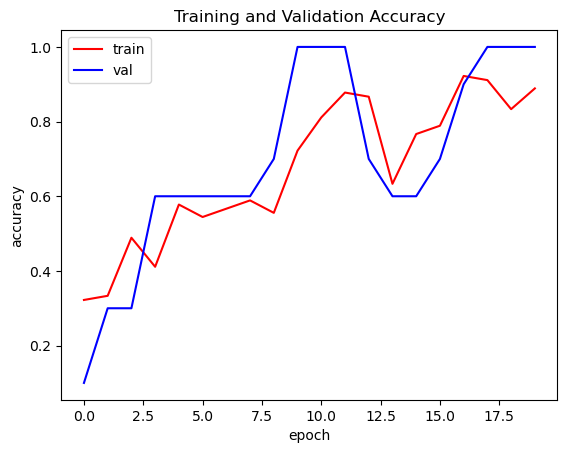

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

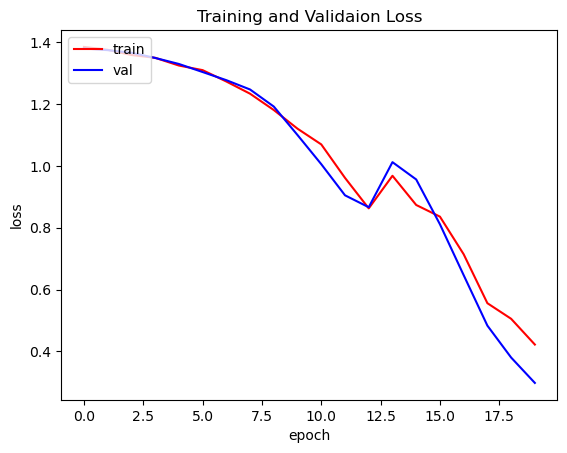

In [11]:
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

In [12]:
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

target_names = [str(label) for label in encoder.classes_]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=target_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
[[3 0 0 0]
 [0 3 0 0]
 [0 0 1 0]
 [0 0 0 3]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         3

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



In [13]:
def predict_intent(text):
    text = text.lower()
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len, padding='post')
    pred = model.predict(padded)
    class_id = np.argmax(pred, axis=1)[0]
    intent_label = label_encoder.inverse_transform([class_id])[0]
    return intent_label

In [14]:
text_input = "berikan data mengani anak di sekolah"
predicted_intent = predict_intent(text_input)

print(f"Teks: {text_input}")
print(f"Prediksi intent: {predicted_intent}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
Teks: berikan data mengani anak di sekolah
Prediksi intent: search_data


# Model Save

In [15]:
model.save("intent.keras")